Data from: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv

In [ ]:
import numpy as np
import pandas as pd
import scipy.special as sp
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import PIL
import json
import os
import datetime

rng = np.random.default_rng(42)

In [ ]:
# df_train = pd.read_csv('mnist_train.csv')
# df_test = pd.read_csv('mnist_test.csv')

print(f'there are {len(df_train)} samples in the train set')
print(f'there are {len(df_test)} samples in the test set')

df_train.columns
df_train.head()

In [ ]:
X_train = df_train.drop(columns='label').to_numpy() / 255
X_test = df_test.drop(columns='label').to_numpy() / 255

Y_train = df_train['label'].to_numpy()
Y_test = df_test['label'].to_numpy()

X_train, Y_train = shuffle(X_train, Y_train)
X_test, Y_test = shuffle(X_test, Y_test)

In [138]:
class MultiClassLogisticRegression(object):
    def __init__(self) -> None:
        self.W = None
        self.b = None

    def encode_targets(self, Y):
        n_classes = len(set(Y))
        T = np.zeros((len(Y), n_classes), dtype=np.int8)
        for ii in range(len(Y)):
            T[ii, Y[ii]] = 1

        return T
    
    def predict(self, pY):
        if pY.ndim > 1:
            return np.argmax(pY, axis=1)
        else:
            return np.argmax(pY)
            
    
    def cross_entropy_loss(self, pY, T):
        return -np.sum(T * np.log(pY))
    
    @staticmethod
    def classification_rate(preds, Y):
        # preds = predict(pY)
        return np.mean(preds == Y)
    
    def forward_pass(self, X, W, b):
        pY = sp.softmax(X.dot(W) + b, axis=1)
        return pY
    
    def derivative_W(self, X, pY, T):
        return X.T.dot(pY - T)
    
    def derivative_b(self, pY, T):
        return np.sum(pY - T, axis=0)

    def get_batches(self, X, Y, batch_size, return_targets: bool = False):
        N = len(X)
        n_batches = int(np.ceil(N / batch_size))
        if return_targets:
            T = self.encode_targets(Y)
            batches = [[X[i*batch_size: (i+1)*batch_size], Y[i*batch_size: (i+1)*batch_size], T[i*batch_size: (i+1)*batch_size]] for i in range(n_batches)] 
        else:
            batches = [[X[i*batch_size: (i+1)*batch_size], Y[i*batch_size: (i+1)*batch_size]] for i in range(n_batches)] 
        return batches

    def fit(self, X, Y, epochs=10**3, learning_rate=1e-5, reg=0, gradient_method: str = 'FGD', batch_size: int = 8, mu: float = 0.0, adaptive_learning_rate: str = None):
        N, D = X.shape
        # initialise weights and biases:
        n_classes = len(set(Y))
    
        self.W = rng.normal(size=(D, n_classes)) / np.sqrt(D)
        self.b = np.zeros((1, n_classes))
    
        cost = []
        error = []
    
        if gradient_method == 'FGD':
            T = self.encode_targets(Y)
            cache_W = 1
            cache_b = 1
            eps = 1e-8
            decay = 0.99 

            for ii in range(epochs):
                pY = self.forward_pass(X, self.W, self.b)

                grad_W = self.derivative_W(X, pY, T) + reg*self.W
                grad_b = self.derivative_b(pY, T) + reg*self.b
                # adaptive learning rates
                if adaptive_learning_rate == 'AdaGrad':
                    cache_W += grad_W**2
                    cache_b += grad_b**2

                    self.W -= learning_rate / np.sqrt(cache_W + eps) * grad_W
                    self.b -= learning_rate / np.sqrt(cache_b + eps) * grad_b
                
                elif adaptive_learning_rate == 'RMSProp':
                    cache_W = decay*cache_W + (1-decay)*grad_W**2
                    cache_b = decay*cache_b + (1-decay)*grad_b**2

                    self.W -= learning_rate / np.sqrt(cache_W + eps) * grad_W
                    self.b -= learning_rate / np.sqrt(cache_b + eps) * grad_b
                
                else: # without adaptive learning rate
                    self.W -= learning_rate * grad_W
                    self.b -= learning_rate * grad_b

                if ii % 20 == 0:
                    cost.append(self.cross_entropy_loss(pY, T))
                    error_rate = 1 - self.classification_rate(self.predict(pY), Y)

                    print(f'FGD. Cost at epoch {ii}: {cost[-1]}, training error rate: {error_rate}')

        elif gradient_method == 'SGD':
            velocity_W = 0 # set initial velocities to 0
            velocity_b = 0

            for ii in range(epochs):
                X, Y = shuffle(X, Y)
                T = self.encode_targets(Y)
                
                for jj in range(N):
                    X_sample, T_sample = X[jj].reshape((1, D)), T[jj]
                    pY = self.forward_pass(X_sample, self.W, self.b)

                    # normal momentum
                    velocity_W = mu*velocity_W - learning_rate*(self.derivative_W(X_sample, pY, T_sample) + reg*self.W)
                    velocity_b = mu*velocity_b - learning_rate*(self.derivative_b(pY, T_sample) + reg*self.b)

                    self.W += velocity_W
                    self.b += velocity_b

                if ii % 20 == 0:
                    cost.append(self.cross_entropy_loss(pY, T_sample))
                    # error_rate = 1 - self.classification_rate(self.predict(pY), Y_sample)
                    # pointless to calculate error on a sample size of one

                    print(f'SGD. Cost at epoch {ii}: {cost[-1]}')

        elif gradient_method == 'MBGD':
            velocity_W = 0 # set initial velocities to 0
            velocity_b = 0

            for ii in range(epochs):
                X, Y = shuffle(X, Y)
                batches = self.get_batches(X, Y, batch_size, return_targets=True)

                for jj in range(len(batches)):
                    X_batch, _, T_batch = batches[jj]
                    pY = self.forward_pass(X_batch, self.W, self.b)

                    # Nestorov momentum
                    grad_W = self.derivative_W(X_batch, pY, T_batch) + reg*self.W
                    grad_b = self.derivative_b(pY, T_batch) + reg*self.b

                    velocity_W = mu*velocity_W - learning_rate*grad_W
                    velocity_b = mu*velocity_b - learning_rate*grad_b

                    self.W += mu*velocity_W - learning_rate*grad_W
                    self.b += mu*velocity_b - learning_rate*grad_b

                if ii % 20 == 0:
                    cost.append(self.cross_entropy_loss(pY, T_batch))
                    # error_rate = 1 - self.classification_rate(self.predict(pY), Y_batch)
                    # slightly more meaningful than for SGD, but still pretty useless

                    print(f'MBGD. Cost at epoch {ii}: {cost[-1]}')

        plt.plot(cost)
        plt.show()
    
    def classify(self, X):
        return self.predict(self.forward_pass(X, self.W, self.b))
        
    def evaluate(self, X_test, Y_test):
        pY = self.forward_pass(X_test, self.W, self.b)
        T = self.encode(self.encode_targets(Y_test))
        error_rate = 1 - self.classification_rate(self.predict(pY), Y_test)
    
        print(f'Error rate: {error_rate}')
    

Using AdaGrad
FGD. Cost at epoch 0: 219.63630077158507, training error rate: 0.83
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
FGD. Cost at epoch 20: 219.20875367432032, training error rate: 0.83
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
FGD. Cost at epoch 40: 218.99179002386023, training error rate: 0.83
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaGrad
Using AdaG

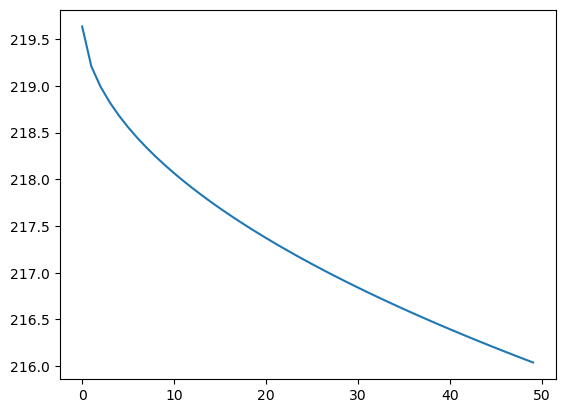

In [139]:
model = MultiClassLogisticRegression()
model.fit(X_train[:100], Y_train[:100], epochs=1000, gradient_method='FGD', mu=0.9, adaptive_learning_rate='AdaGrad')